# Hands-On Graph Analysis with scikit-network

This notebook shows how to apply `scikit-network` to analyse network structures. It is focused on the core components of the library, and the goal is to play with very simple graphs to get a hang of the internals.

We will look at a custom toy graph, as well as the famous _Karate Club_ network.


## Import

To install scikit-network, please execute the following command and restart the kernel:

In [9]:
!pip install scikit-network

In [10]:
from IPython.display import SVG

In [11]:
import numpy as np
import scipy
from scipy import sparse
from matplotlib import pyplot as plt

In [55]:
from sknetwork.hierarchy import LouvainHierarchy, cut_straight
from sknetwork.clustering import Louvain
from sknetwork.topology import Triangles, Cliques, is_connected, get_connected_components, are_isomorphic, WeisfeilerLehman
from sknetwork.topology import CoreDecomposition
from sknetwork.ranking import Katz, Betweenness
from sknetwork.utils import Bunch
from sknetwork.data import load_netset, karate_club
from sknetwork.ranking import PageRank, top_k
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.embedding import Spectral
from sknetwork.linalg import normalize
from sknetwork.utils import WardDense, get_neighbors, membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph, svg_dendrogram

# Toy graph

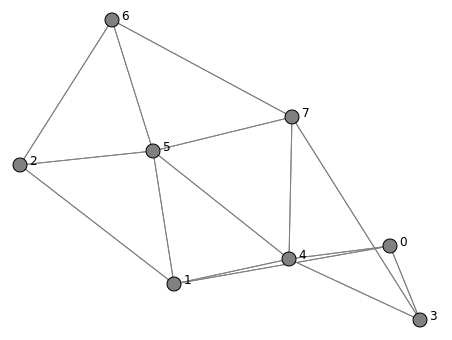

In [14]:
# toy graph
data = np.array([
    [0, 1, 0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 1, 1, 0],
    [1, 0, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 1, 0, 1],
    [0, 1, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 1, 1, 0]
])
csr_dat = sparse.csr_matrix(data)

# Create a bunch object: this is the graph
graph = Bunch(adjacency=csr_dat, names=np.arange(8))
SVG(svg_graph(graph.adjacency, names=graph.names))

In [15]:
graph.adjacency.indices

array([1, 3, 4, 0, 2, 4, 5, 1, 5, 6, 0, 4, 7, 0, 1, 3, 5, 7, 1, 2, 4, 6,
       7, 2, 5, 7, 3, 4, 5, 6], dtype=int32)

In [16]:
graph.adjacency.indptr

array([ 0,  3,  7, 10, 13, 18, 23, 26, 30], dtype=int32)

In [17]:
graph.adjacency.data

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
# number of nodes, edges
num_nodes = len(graph.adjacency.indptr) - 1
num_edges = len(graph.adjacency.data)
print(f"There are {num_nodes} nodes and {num_edges} edges in the graph.")

There are 8 nodes and 30 edges in the graph.


## Neighbourhood and degrees

Let us find the neighbours of any given node $i$, as well as its degree (its number of distinct neighbours).

In [19]:
i = 1
x = graph.adjacency.indptr
neighbourhood = graph.adjacency.indices[x[i]:x[i+1]]
neighbourhood

array([0, 2, 4, 5], dtype=int32)

In [20]:
len(graph.adjacency.indices[x[i]:x[i+1]])

4

## Density

In [21]:
density = num_edges / (num_nodes * (num_nodes - 1))
density

0.5357142857142857

## Visualizing the graph

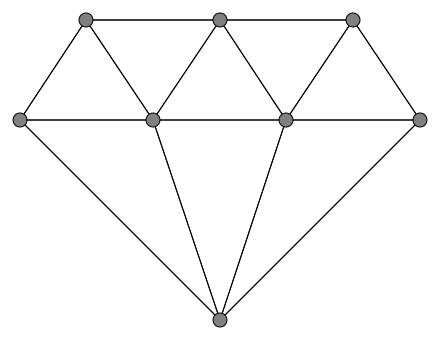

In [22]:
# position and vis
graph.position = np.array([
    [1,3],
    [3,3],
    [5,3],
    [0,2],
    [2,2],
    [4,2],
    [6,2],
    [3,0]
])
SVG(svg_graph(graph.adjacency, position=graph.position))

# Karate club

Let us move on to a small real-world example for the rest of the tutorial. Zachary's Karate Club shows the relations between members of a karate club in the 1970s.

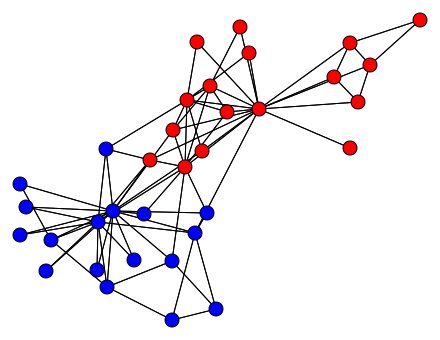

In [23]:
# karate club
k_graph = karate_club(metadata=True)
SVG(svg_graph(k_graph.adjacency, labels=k_graph.labels))

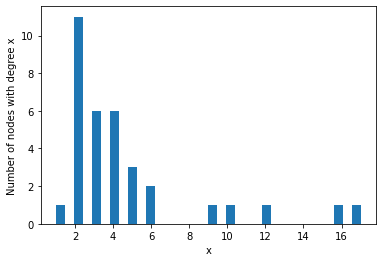

In [24]:
num_nodes = len(k_graph.adjacency.indptr) - 1
num_edges = len(k_graph.adjacency.data)
x = k_graph.adjacency.indptr
degree = lambda i: len(k_graph.adjacency.indices[x[i]:x[i+1]])
degrees = [ degree(i) for i in range(num_nodes)]
_ = plt.hist(degrees, bins=num_nodes)
plt.xlabel("x")
plt.ylabel("Number of nodes with degree x")
plt.show()

## Topology

Let us get connected components, count triangles, cliques, and look at the core decomposition of the graph.

In [25]:
is_connected(k_graph.adjacency)

True

In [26]:
conn_comps = get_connected_components(k_graph.adjacency)
conn_comps

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

### Triangles and cliques

In [27]:
tr = Triangles()
tr_res = tr.fit_transform(k_graph.adjacency)
tr_res

45

In [28]:
cliques = Cliques(4)
cliques_res = cliques.fit_transform(graph.adjacency)
cliques_res

0

### Core decomposition

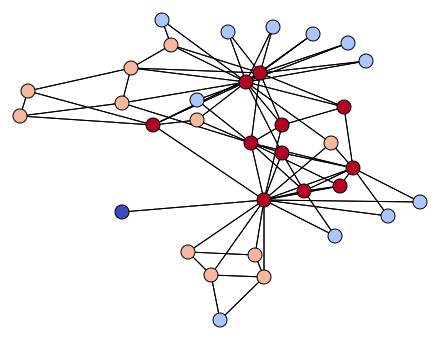

In [29]:
core = CoreDecomposition()
labels = core.fit_transform(k_graph.adjacency)
image = svg_graph(k_graph.adjacency, k_graph.position, scores=labels)
SVG(image)

### Isomorphism Isomorphism and Weisfeiler-Lehman    

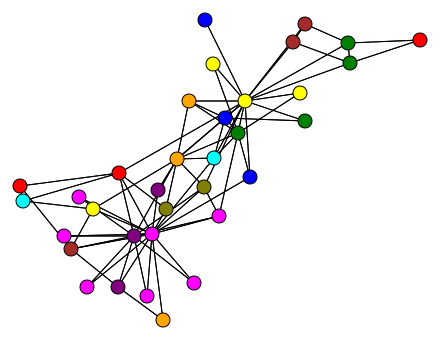

In [30]:
weisfeiler_lehman = WeisfeilerLehman()
labels = weisfeiler_lehman.fit_transform(k_graph.adjacency)

SVG(svg_graph(k_graph.adjacency, labels=labels))

In [31]:
are_isomorphic(graph.adjacency, k_graph.adjacency)

False

## Centralities

Let us try to find central nodes in the Karate Club graph. We will compare betweenness centrality, Katz centrality and PageRank.

In [32]:
bw = Betweenness()
bw_scores = bw.fit_transform(k_graph.adjacency)
bw_scores

array([231.07143021,  28.47857147,  75.85079345,   6.28809533,
         0.33333334,  15.83333336,  15.83333336,   0.        ,
        29.52936514,   0.44761906,   0.33333334,   0.        ,
         0.        ,  24.21587315,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  17.14682536,
         0.        ,   0.        ,   0.        ,   9.3       ,
         1.16666668,   2.02777777,   0.        ,  11.79206363,
         0.94761907,   1.54285717,   7.60952402,  73.00952414,
        76.69047808, 160.55158979])

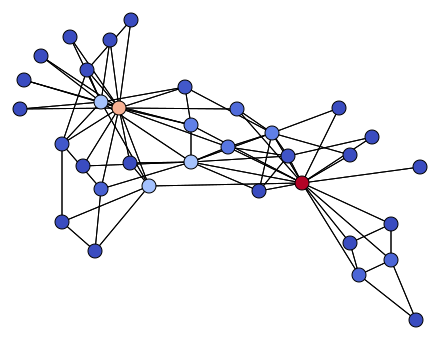

In [34]:
SVG(svg_graph(k_graph.adjacency, scores=bw_scores))

In [36]:
katz = Katz()
katz_scores = katz.fit_transform(k_graph.adjacency)
katz_scores

array([312.375 , 231.0625, 279.625 , 187.    ,  74.625 ,  79.75  ,
        79.75  , 154.25  , 210.375 ,  95.0625,  74.625 ,  50.75  ,
        77.75  , 208.    ,  96.625 ,  96.625 ,  24.875 ,  85.9375,
        96.625 , 139.6875,  96.625 ,  85.9375,  96.625 , 141.375 ,
        51.75  ,  53.9375,  71.4375, 124.3125, 119.75  , 126.5   ,
       159.9375, 183.3125, 269.6875, 320.0625])

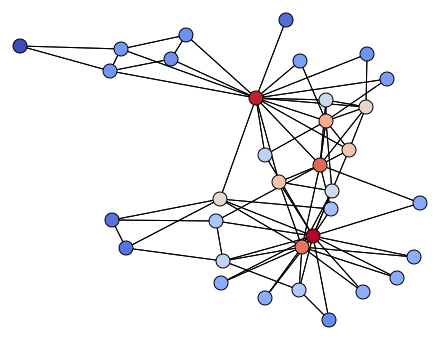

In [37]:
SVG(svg_graph(k_graph.adjacency, scores=katz_scores))

## Clustering

In [38]:
import sknetwork as skn

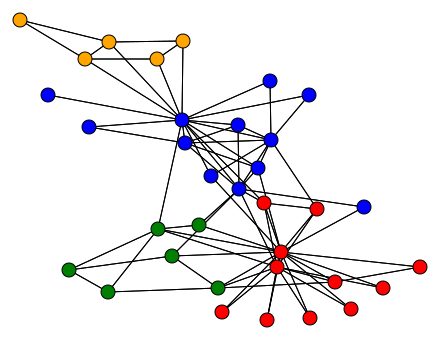

In [59]:
lvn = skn.clustering.Louvain()
lvn_labels = lvn.fit_transform(k_graph.adjacency)
SVG(svg_graph(k_graph.adjacency, labels=lvn_labels))

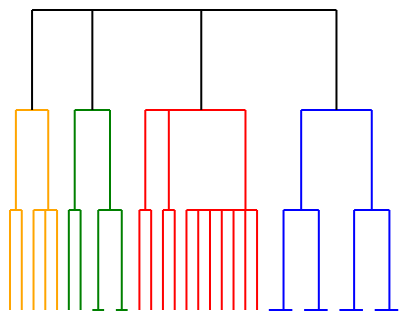

In [60]:
louvain_hierarchy = LouvainHierarchy()
dendrogram = louvain_hierarchy.fit_transform(k_graph.adjacency)

SVG(svg_dendrogram(dendrogram))

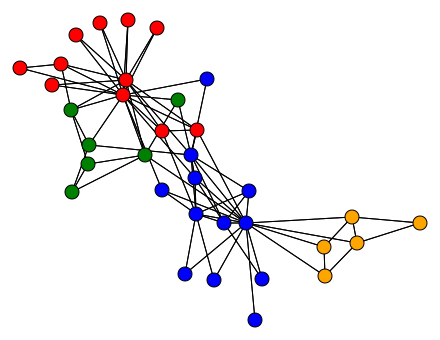

In [69]:
labels, dendrogram_aggregate = cut_straight(dendrogram, n_clusters=4, return_dendrogram=True)
SVG(svg_graph(k_graph.adjacency, labels=labels))